# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

## Helper functions
Set of helper functions

In [2]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



def show_plot(iteration,loss):

    ax.clear()
    ax.plot(iteration,loss)
    fig.canvas.draw()


## Custom Dataset Class
This dataset generates a pair of images

In [6]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        should_get_same_class = random.randint(0,1) #we need to make sure approx 50% of images are in the same class

        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) #keep looping till the same class image is found
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)# inverting the images to make it black text on white background
            img1 = PIL.ImageOps.invert(img1)#

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        print(len(self.imageFolderDataset.imgs))
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [7]:
folder_dataset = dset.ImageFolder(root='./data/faces/training/')

In [8]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
0 indiciates dissimilar, and 1 indicates similar.

381


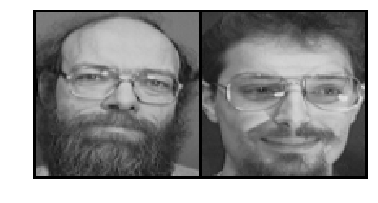

[[ 1.]]


In [9]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)
dataiter = iter(vis_dataloader)



example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),


            
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.Dropout2d(p=.2),

            
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(8, 8, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.Dropout2d(p=.2),

            
    
        
            
#             nn.BatchNorm2d(20),
            
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(20, 20, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(20),
            
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(20, 20, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(20) 
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
#             nn.Dropout(),

#             nn.BatchNorm1d(150),
            
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
#             nn.Dropout(),


#             nn.BatchNorm1d(100),
            
            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


## Contrastive Loss

In [11]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on:
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        # euclidian distance
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

## Training Time!

In [12]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=6,
                        batch_size=64)

381


In [13]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [14]:
# for param_group in optimizer.param_groups:
#     param_group['lr'] = 0.00001

In [15]:
counter = []
loss_history = [] 
iteration_number= 0

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Epoch number 1
 Current loss 11.76566219329834

Epoch number 2
 Current loss 8.538005828857422

Epoch number 3
 Current loss 7.68039608001709

Epoch number 4
 Current loss 6.0970048904418945

Epoch number 5
 Current loss 5.366545677185059

Epoch number 6
 Current loss 6.9404683113098145

Epoch number 7
 Current loss 4.589461803436279

Epoch number 8
 Current loss 5.681575298309326

Epoch number 9
 Current loss 4.735311985015869

Epoch number 10
 Current loss 4.549322605133057

Epoch number 11
 Current loss 3.860013246536255

Epoch number 12
 Current loss 4.191351890563965

Epoch number 13
 Current loss 3.2811739444732666

Epoch number 14
 Current loss 3.823131561279297

Epoch number 15
 Current loss 4.11538028717041

Epoch number 16
 Current loss 3.8683464527130127

Epoch number 17
 Current loss 3.4527206420898438

Epoch number 18
 Current loss 2.6138052940368652

Epoch number 19
 Current loss 3.267915725708008

Epoch number 20
 Current loss 3.027510643005371

Epoch number 21
 Current 

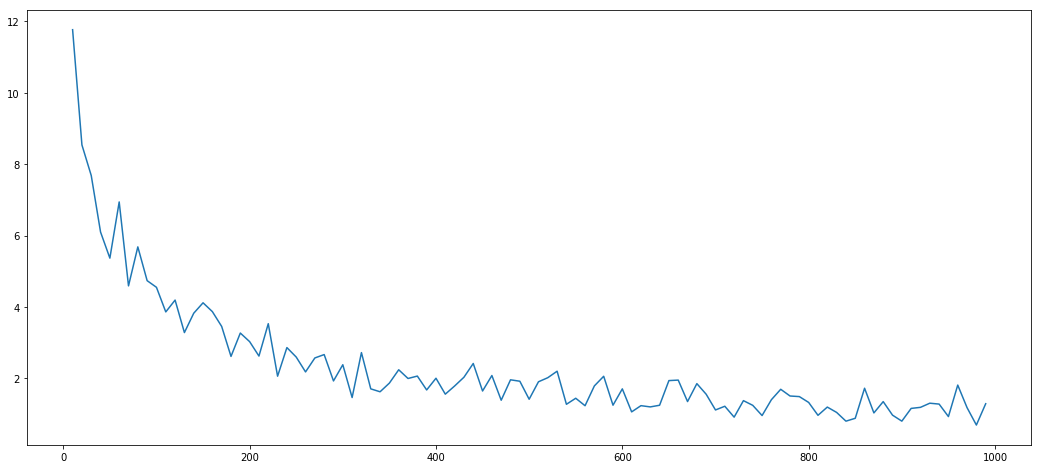

In [16]:


fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()




for epoch in range(1,100):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(5 - euclidean_distance, min=0.0), 2))
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
            show_plot(counter,loss_history)

        


In [17]:
print(random.choice(folder_dataset.imgs))
print(random.choice(folder_dataset.imgs))

('./data/faces/training/s25/8.pgm.png', 17)
('./data/faces/training/s1/1.pgm.png', 0)


In [19]:
test_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=1,
                        batch_size=1)
test_iter = iter(test_dataloader)

im1,im2, label = next(test_iter)


381


In [ ]:
test1 = Image.open('./data/omniglot/Latin/character01/0683_01.png')
test1 = test1.resize((100,100))
test1 = np.array(test1,dtype=np.float32)
test1 = torch.from_numpy(test1)
test1 = torch.unsqueeze(torch.unsqueeze(test1,0),0)



test2 = Image.open('./data/omniglot/Latin/character01/0683_03.png')
test2 = test2.resize((100,100))
test2 = np.array(test2,dtype=np.float32)
test2 = torch.from_numpy(test2)
test2 = torch.unsqueeze(torch.unsqueeze(test2,0),0)

In [ ]:
imshow(torchvision.utils.make_grid(torch.cat([test1,test2])))

In [ ]:
output1,output2 = net(Variable(test1).cuda(),Variable(test2).cuda())

euclidean_distance = F.pairwise_distance(output1, output2)
print (euclidean_distance.cpu().data[0].numpy())

In [20]:
foler = dset.ImageFolder(root='./data/faces/testing/')
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=foler,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()])
                                       ,should_invert=False)
test_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=1,
                        batch_size=1)

dataiter = iter(test_dataloader)

x0,_,label = next(dataiter)




30


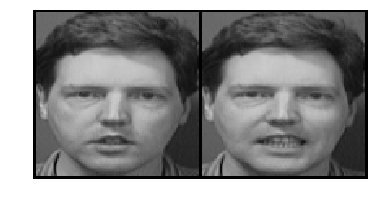

[[ 0.87303126]]


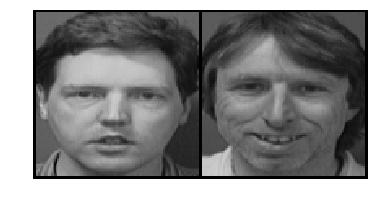

[[ 2.63330317]]


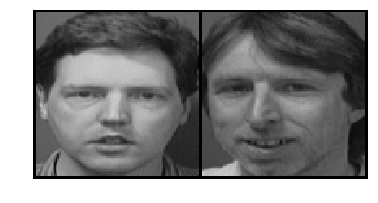

[[ 2.24506974]]


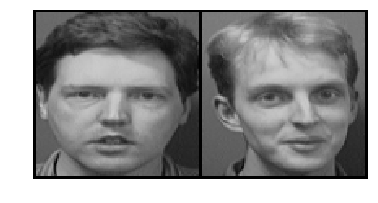

[[ 3.99888325]]


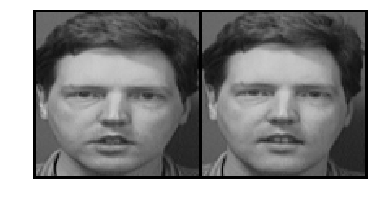

[[ 0.65588319]]


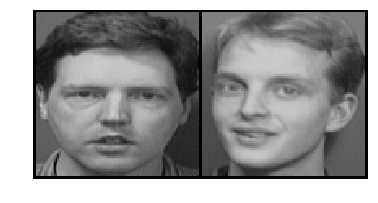

[[ 2.59311604]]


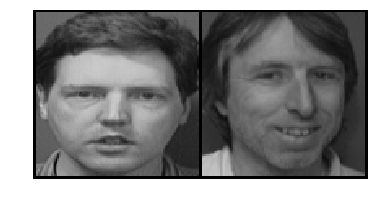

[[ 3.90833688]]


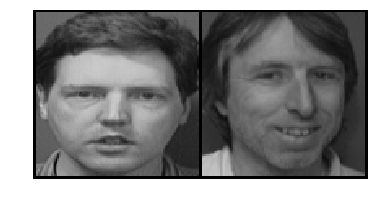

[[ 4.24210024]]


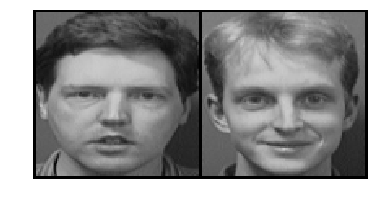

[[ 3.43860912]]


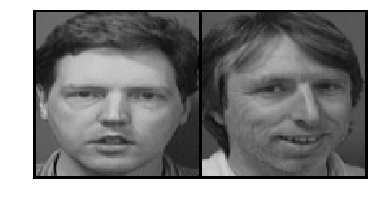

[[ 1.00002503]]


In [21]:
for i in range(10):
    dataiter = iter(test_dataloader)
    _,x1,label2 = next(dataiter)


    concatenated = torch.cat((x0,x1),0)
    imshow(torchvision.utils.make_grid(concatenated))
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())

    euclidean_distance = F.pairwise_distance(output1, output2)
    print (euclidean_distance.cpu().data.numpy())

